# Pipelines

If we learn something so far, that is machine learning is not only applying an algorithm and get the predictions.(Not so much commodization after all) It has quite a lot of different and moving parts for a given problem.

> Steps(feature extraction, feature selection, classifier, evaluation) follows a sequential order, though. 

- Would it be perfect if we could wrap all of the steps in one object and then do the parameter search(i.e. grid parameter search) for cross validation in that object. 
- Further, if we have two estimators in the __pipeline__(say we apply PCA to reduce dimension in the input and then apply SVM), we would need only once to use the `fit` function in the estimator. 

> Pipeline automatically applies the correct steps for you to get the correct output at the end of the pipeline. 

- Still not convinced? What if I say, serializing one `pipeline` instead of serializing `vectorizer`, `feature_selector` and `classifier` separately and then deploying into production makes much easier.(More on to this in the next notebook) This was a quick win for the pipeline. Let's see how one might use it in classification.

# Why do we need pipelines

- The basic API requires us to go through a series of steps common to most analyses
- We need to perform the same things if we build a slightly different model
- Parameter optimizations need to be handled separately for preprocessing steps and for model selection

In [ ]:
from sklearn.datasets import load_boston
from pandas import Series, DataFrame
bos = load_boston()

In [ ]:
bos.keys()

In [ ]:
X = DataFrame(bos['data'], columns = bos['feature_names'])
y = bos['target']

In [ ]:
X.shape

### Regular Method of Building Models is to go step-by-step <br> and use the output of one step as input of the next step

In [ ]:
# Step 1 - Scaling
# From x to x_scaled

from sklearn.preprocessing import RobustScaler
robsc = RobustScaler() 
X_scaled = robsc.fit_transform(X)

In [ ]:
# Step 2
# from x_scaled to x_pca

from sklearn.decomposition import PCA
pca_10 = PCA(n_components=10, whiten=True)

X_pca = pca_10.fit_transform(X_scaled)

In [ ]:
# Step 3
# build the model

from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV

grid = {'C': [0.01, 0.1, 1, 10],
       'kernel': ['linear', 'rbf', 'poly']}

gscv_svr = GridSearchCV(estimator=SVR(), param_grid=grid, cv=5, verbose=True)

gscv_svr.fit(X_pca, y)

gscv_svr.best_estimator_.predict(X_pca)

---

Some might find this process needlessly verbose.
There is a way to limit the amount of typing that needs to be done in order to accomplish the same tasks.

> ### Pipeline can be used to chain multiple estimators/transformers into one. 

This is useful as there is often a **fixed sequence of steps in processing the data**, for example 

- feature selection, 
- normalization and 
- classification. 

Pipeline serves two purposes here:

- **Convenience**: You only have to call fit and predict once on your data to fit a whole sequence of estimators.
- **Joint parameter selection**: You can grid search over parameters of all estimators in the pipeline at once.

> #### [PS] All estimators in a pipeline, except the last one, must be transformers (i.e. must have a transform method). The last estimator may be any type (transformer, classifier, etc.).


The purpose of the pipeline is to assemble several steps that can be
cross-validated together while setting different parameters.

---

### Build a basic Pipeline (without GridSearch)

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression

In [ ]:
# Give names of steps with make_pipeline
pipe_1 = make_pipeline(RobustScaler(), PCA(n_components=10), LinearRegression())

# Give names + aliases in tuples with Pipeline()
pipe_2 = Pipeline([('scale', RobustScaler()), 
                  ('pca', PCA(n_components=10)), 
                  ('lr', LinearRegression())])

In [ ]:
pipe_2.fit(X, y)

In [ ]:
pipe_2.predict(X)[:10]

### Pipelines with GridSearch

In [ ]:
# Regular Grid Search for SVM with preprocessing using PCA 

from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)


from sklearn.grid_search import GridSearchCV
param_grid = {'C': 10. ** np.arange(-3, 3),
              'gamma': 10. ** np.arange(-3, 3)}

grid = GridSearchCV(SVC(), 
                    param_grid=param_grid,
                    verbose=True,
                    scoring='accuracy'
                    n_jobs=-1)

grid.fit(X_pca, y_train)
grid.predict(X_test)

In [ ]:
# Combine them
import numpy as np
from sklearn.svm import SVC

pipe_svm = Pipeline([('pca', PCA()), 
                     ('svm', SVC())])

param_grid = {'pca__n_components': [5, 10, 15],
              'svm__C': 10. ** np.arange(-3, 3), 
              'svm__gamma': 10. ** np.arange(-3, 3)
             }

grid = GridSearchCV(pipe_svm, 
                    param_grid=param_grid, 
                    cv=5,
                   scoring='recall',
                   n_jobs=-1)

grid.fit(X, y)

# Example

In [1]:
from sklearn.datasets import load_digits
X = load_digits()['data']
y = load_digits()['target']

In [2]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

## Pipeline for Logistic Regression with Scaling and PCA

In [6]:
# 1 - Set up the pipeline
pipe_logit = Pipeline(steps=[('scale', StandardScaler()), 
                             ('pca', PCA()),
                             ('logit', LogisticRegression())])

In [7]:
# 2 - Set up the pipeline grid
params_pipe_logit = {'logit__C': [10, 1, 0.1, 0.01],
                     'logit__penalty': ['l1', 'l2'],
                     'pca__n_components': [20, 30, 40]}

# 3 - Set up the grid search by passing the pipe and pipe grid
gscv_pipe_1 = GridSearchCV(estimator=pipe_logit, 
                           param_grid=params_pipe_logit, 
                           scoring='accuracy',
                           cv=3,
                           verbose=1)

In [8]:
# 4 - Use the fit, predict methods of the grid

# Fit
gscv_pipe_1.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   12.1s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   13.3s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, n_components=None, whiten=False)), ('logit', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'pca__n_components': [20, 30, 40], 'logit__penalty': ['l1', 'l2'], 'logit__C': [10, 1, 0.1, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=1)

In [9]:
# Best Params
print gscv_pipe_1.best_params_

{'pca__n_components': 40, 'logit__penalty': 'l2', 'logit__C': 1}


In [10]:
# Predict
y_pred = gscv_pipe_1.predict(X_test)

In [11]:
# Measure Performance
accuracy_score(y_pred, y_test)

0.94444444444444442

In [12]:
gscv_pipe_1.grid_scores_[:4]

[mean: 0.93041, std: 0.00362, params: {'pca__n_components': 20, 'logit__penalty': 'l1', 'logit__C': 10},
 mean: 0.94224, std: 0.00584, params: {'pca__n_components': 30, 'logit__penalty': 'l1', 'logit__C': 10},
 mean: 0.94224, std: 0.00816, params: {'pca__n_components': 40, 'logit__penalty': 'l1', 'logit__C': 10},
 mean: 0.93180, std: 0.00823, params: {'pca__n_components': 20, 'logit__penalty': 'l2', 'logit__C': 10}]

---
## Pipeline for SVM with Scaling and SelectKBest

In [16]:
import numpy as np
from sklearn.feature_selection import SelectKBest

In [17]:
# Set up the pipe
pipe_rf = Pipeline(steps=[('scale', StandardScaler()), 
                          ('skb', SelectKBest()),
                          ('svm', SVC())])

# Set up the Grid
params_pipe_rf = {'svm__kernel': ['linear', 'rbf', 'sigmoid'],
                  'svm__C': 10 ** np.arange(-2.0, 2.0, 1.0),
                  'skb__k': [20, 25, 35, 50]}

# Grid Search
gscv_pipe_rf = GridSearchCV(estimator = pipe_rf,
                            param_grid = params_pipe_rf,
                            scoring='f1_weighted',
                            cv=3,
                            verbose=1)

# Fit
gscv_pipe_rf.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/Users/lr/anaconda2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 0 24 32 39] are constant.
  UserWarning)
/Users/lr/anaconda2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/lr/anaconda2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 0 32 39 56] are constant.
  UserWarning)
/Users/lr/anaconda2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 0 32 39] are constant.
  UserWarning)
/Users/lr/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    5.5s
[Parallel(n_jobs=1)]: Done

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('skb', SelectKBest(k=10, score_func=<function f_classif at 0x1071aae60>)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'svm__C': array([  0.01,   0.1 ,   1.  ,  10.  ]), 'svm__kernel': ['linear', 'rbf', 'sigmoid'], 'skb__k': [20, 25, 35, 50]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1_weighted',
       verbose=1)

In [18]:
gscv_pipe_rf.best_params_

{'skb__k': 50, 'svm__C': 10.0, 'svm__kernel': 'rbf'}

In [20]:
gscv_pipe_rf.grid_scores_[:10]

[mean: 0.92834, std: 0.00827, params: {'svm__C': 0.01, 'svm__kernel': 'linear', 'skb__k': 20},
 mean: 0.02049, std: 0.00020, params: {'svm__C': 0.01, 'svm__kernel': 'rbf', 'skb__k': 20},
 mean: 0.02049, std: 0.00020, params: {'svm__C': 0.01, 'svm__kernel': 'sigmoid', 'skb__k': 20},
 mean: 0.93210, std: 0.00814, params: {'svm__C': 0.10000000000000001, 'svm__kernel': 'linear', 'skb__k': 20},
 mean: 0.91718, std: 0.01364, params: {'svm__C': 0.10000000000000001, 'svm__kernel': 'rbf', 'skb__k': 20},
 mean: 0.02049, std: 0.00020, params: {'svm__C': 0.10000000000000001, 'svm__kernel': 'sigmoid', 'skb__k': 20},
 mean: 0.92667, std: 0.00805, params: {'svm__C': 1.0, 'svm__kernel': 'linear', 'skb__k': 20},
 mean: 0.95328, std: 0.00705, params: {'svm__C': 1.0, 'svm__kernel': 'rbf', 'skb__k': 20},
 mean: 0.02049, std: 0.00020, params: {'svm__C': 1.0, 'svm__kernel': 'sigmoid', 'skb__k': 20},
 mean: 0.90910, std: 0.01684, params: {'svm__C': 10.0, 'svm__kernel': 'linear', 'skb__k': 20}]

In [21]:
gscv_pipe_rf.best_score_

0.98539568111664155

### Predict using the best model

In [22]:
y_pred = gscv_pipe_rf.predict(X_test)

In [23]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

accuracy_score(y_test, y_pred)

0.98611111111111116

In [24]:
confusion_matrix(y_test, gscv_pipe_rf.best_estimator_.predict(X_test))

array([[39,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 29,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 37,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 34,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 40,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 40,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 41,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 31,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0, 35,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  1,  0, 29]])

In [25]:
print classification_report(y_test, gscv_pipe_rf.best_estimator_.predict(X_test))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        39
          1       0.97      1.00      0.98        29
          2       1.00      1.00      1.00        37
          3       1.00      0.97      0.99        35
          4       1.00      1.00      1.00        40
          5       0.95      0.98      0.96        41
          6       0.98      1.00      0.99        41
          7       0.97      1.00      0.98        31
          8       1.00      0.97      0.99        36
          9       1.00      0.94      0.97        31

avg / total       0.99      0.99      0.99       360



In [26]:
import pandas as pd
df_1 = pd.DataFrame(gscv_pipe_rf.grid_scores_)
df_1.columns

Index([u'parameters', u'mean_validation_score', u'cv_validation_scores'], dtype='object')

In [33]:
df_1.sort_values('mean_validation_score', ascending=False)[:10].loc[:, 'parameters'].tolist()

[{'skb__k': 50, 'svm__C': 10.0, 'svm__kernel': 'rbf'},
 {'skb__k': 35, 'svm__C': 10.0, 'svm__kernel': 'rbf'},
 {'skb__k': 50, 'svm__C': 1.0, 'svm__kernel': 'rbf'},
 {'skb__k': 35, 'svm__C': 1.0, 'svm__kernel': 'rbf'},
 {'skb__k': 50, 'svm__C': 0.10000000000000001, 'svm__kernel': 'linear'},
 {'skb__k': 50, 'svm__C': 10.0, 'svm__kernel': 'linear'},
 {'skb__k': 50, 'svm__C': 1.0, 'svm__kernel': 'linear'},
 {'skb__k': 50, 'svm__C': 0.01, 'svm__kernel': 'linear'},
 {'skb__k': 25, 'svm__C': 1.0, 'svm__kernel': 'rbf'},
 {'skb__k': 25, 'svm__C': 10.0, 'svm__kernel': 'rbf'}]

## Explore the Grid Scores to choose a different model for production

- Tradeoff Complexity vs. Generalizability

In [ ]:
pd.concat([pd.DataFrame(df_1['parameters'].tolist()),
           df_1['mean_validation_score']], axis=1).sort_values('mean_validation_score', ascending=False).iloc[:10, :]

---
## Pipeline For Text Mining

In [34]:
%matplotlib inline
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import cross_validation 
from sklearn import datasets
from sklearn import decomposition
from sklearn import ensemble
from sklearn import feature_extraction
from sklearn import feature_selection
from sklearn import grid_search
from sklearn import metrics
from sklearn import naive_bayes
from sklearn import pipeline
from sklearn import tree

import seaborn as sns

pd.set_option('display.max_columns', None)

_DATA_DIR ='data'
_SPAM_DATA_PATH = os.path.join(_DATA_DIR, 'SMSSpamCollection')

### [Dataset Explanation](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)
- A collection of 425 SMS spam messages was manually extracted from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages. The Grumbletext Web site is: [Web Link]. 
<br><br>
- A subset of 3,375 SMS randomly chosen ham messages of the NUS SMS Corpus (NSC), which is a dataset of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The messages largely originate from Singaporeans and mostly from students attending the University. These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available. The NUS SMS Corpus is avalaible at: [Web Link]. <br><br>
- A list of 450 SMS ham messages collected from Caroline Tag's PhD Thesis available at [Web Link]. <br><br>
- Finally, we have incorporated the SMS Spam Corpus v.0.1 Big. It has 1,002 SMS ham messages and 322 spam messages and it is public available at: [Web Link]. <br><br>



In [35]:
df = pd.read_csv('./smsspamcollection/SMSSpamCollection', sep='\t', header=None, names=['Label', 'Text'])

In [36]:
df.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Nothing very fancy. Let's convert the pandas dataframe into a numpy matrix, and then do a cross validation.

In [39]:
y = (df.Label == 'ham').values.astype(int)
X = df.Text.values

In [41]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0)

### Let's Create our pipeline

---
`CountVectorizer` helps you find a word count for each word in a document.
This converts a document into a Pandas Series with the word as the index and the count as the value.
Iterating over all documents (for ex, 300 sms's) we get many such Series that are then assembled into a dataFrame.
That's how we convert a column of text into a dataframe with numbers on which we can perform machine learning

---

In [51]:
sent1 = "Sachin Tendulkar scored over ten thousand runs in limited overs cricket."
sent2 = "Cricket and football are the most watched sports in the world"
sent3 = "The mitochondria is the powerhouse of the cell."
sent4 = "Inside the nucleus of a cell, we find the DNA for any animal."

In [45]:
from pandas import Series, DataFrame

In [48]:
def counter(sent):
    return Series({word:sent.count(word) for word in sent.split(' ')})

In [52]:
counter(sent1)

Sachin       1
Tendulkar    1
cricket.     1
in           2
limited      1
over         2
overs        1
runs         1
scored       1
ten          1
thousand     1
dtype: int64

In [53]:
counter(sent2)

Cricket     1
and         1
are         1
football    1
in          1
most        1
sports      1
the         2
watched     1
world       1
dtype: int64

> Each word will become a column in a DataFrame and the rows will be counts of that word in each document.

### Let's do this on the real data

In [55]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [77]:
from sklearn.naive_bayes import BernoulliNB

pipe = Pipeline(steps=[('vect', CountVectorizer()),
                       ('tfidf', TfidfTransformer()),
                       ('bernoulli', BernoulliNB())])

In [78]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...e_idf=True)), ('bernoulli', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))])

Functions that are applicable to estimators are also applicable to Pipelines. That is one of the most powerful premise of the pipeline after all. 

In [79]:
accuracy_score(pipe.predict(X_test), y_test)

0.98116591928251118

By now, we know that this score is not very meaningful, let's look at the confusion matrix!

Populating the interactive namespace from numpy and matplotlib


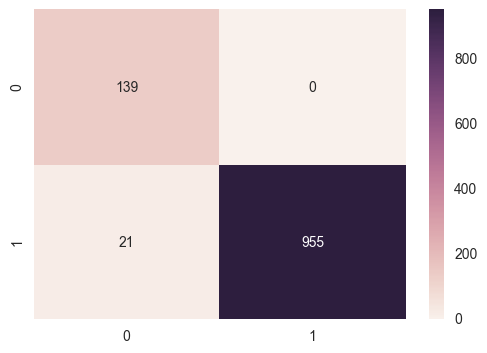

In [80]:
import seaborn as sns
%pylab inline
sns.heatmap(confusion_matrix(pipe.predict(X_test), y_test), annot=True,  fmt='');

In [81]:
print(classification_report(pipe.predict(X_test), y_test))

             precision    recall  f1-score   support

          0       0.87      1.00      0.93       139
          1       1.00      0.98      0.99       976

avg / total       0.98      0.98      0.98      1115



This is actually pretty good. We classify all of the spam as spam whereas couple of normal messages get into spam folder. Not ideal but pretty good for our first try. 

Upto here, you may start convincing yourself how pipeline would be much better and useful and easier than applying each separate component in the machine learning pipeline. 

#### Grid Search in Pipeline

One might apply grid search to the pipeline similar to what we did on the estimator as well. Then one may ask, how do we pass parameters for vectorizer, feature selector and classifier. In the grid search of an estimator, this would be easy as you could pass a `dictionary` which has the keys for the parameters and the parameters as lists that you want to optimize. However, the things in `pipeline` is not that straightforward. First, what if two estimators share the same parameter name and you want to give different values in the search space. What if you do not want to pass any list of parameter to one and pass to the other one? In order to handle this ambiguity, `pipeline` accepts parameters in the form of `{name}__{parameter}` in the dictionary where the `{name}` is the name of the step that you are passing to the pipeline and the parameter is the parameter name that you want to optimize in that step.

<h4> Why double leading underscore?</h4>
> <b>__double_leading_underscore</b>: when naming a class attribute, invokes name mangling (inside class FooBar, __boo becomes _FooBar__boo; ) 

From [PEP 8](http://legacy.python.org/dev/peps/pep-0008/)

In the pipeline, we have only two steps: `pca` and `gbf`. There will be two different parameter family in the parameters dictionary; the ones that start with `vectorizer` and the ones start with `gbf`, both of the parameter names will be followed by `__`(double underscore) and then the original parameter name. For an example, if I want to pass `n_estimators` as a parameter to `GradientBoostingClassifier` which was named `gbf` in the pipeline, I need to pass as `gbf_n_estimators`. Since I will be looking at different values for each parameter, I will pass a list in the values of that dictionary.

In [82]:
CountVectorizer?

In [83]:
TfidfTransformer?

In [84]:
BernoulliNB?

In [85]:
params = dict(vect__max_df=[0.5, 1.0],
              vect__max_features=[None, 10000, 200000],
              vect__ngram_range=[(1, 1), (1, 2)],
              tfidf__use_idf=[True, False],
              tfidf__norm=['l1', 'l2'],
              bernoulli__alpha=[0, .5, 1],
              bernoulli__binarize=[None, .1, .5],
              bernoulli__fit_prior=[True, False]
             )

After preparing the parameters, we are ready to pass this parameter and the pipeline to the `RandomizedSearchCV`.

Wait, what? I thought we are using `GridSearchCV` like we did earlier notebook. Oh, that. Instead of searching __all__ the parameters in the parameter space, `RandomizedSearchCV` makes a randomized search. The total number of parameters that have been tried for optimizing the search parameters is determined by an optional parameter `n_iter`. If you set the `n_iter` to be 20, then 20 different total number of parameter combinations will be tried out in optimizing the parameter search space. 

In [87]:
from sklearn.grid_search import RandomizedSearchCV
RandomizedSearchCV?

In [88]:
n_iter_search = 100
random_search = RandomizedSearchCV(pipe, 
                                   param_distributions=params,
                                   n_iter=n_iter_search)

In [89]:
random_search.fit(X_train, y_train)

/Users/lr/anaconda2/lib/python2.7/site-packages/sklearn/naive_bayes.py:766: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc)


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...e_idf=True)), ('bernoulli', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))]),
          fit_params={}, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'vect__ngram_range': [(1, 1), (1, 2)], 'vect__max_df': [0.5, 1.0], 'tfidf__use_idf': [True, False], 'tfidf__norm': ['l1', 'l2'], 'bernoulli__binarize': [None, 0.1, 0.5], 'bernoulli__fit_prior': [True, False], 'bernoulli__alpha': [0, 0.5, 1], 'vect__max_features': [None, 10000, 200000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring=None, verbose=0)

In [90]:
random_search.best_params_

{'bernoulli__alpha': 0.5,
 'bernoulli__binarize': 0.1,
 'bernoulli__fit_prior': False,
 'tfidf__norm': 'l2',
 'tfidf__use_idf': True,
 'vect__max_df': 0.5,
 'vect__max_features': None,
 'vect__ngram_range': (1, 1)}

In [91]:
random_search.best_estimator_

Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.5, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st..._idf=True)), ('bernoulli', BernoulliNB(alpha=0.5, binarize=0.1, class_prior=None, fit_prior=False))])

In [92]:
random_search.best_score_

0.9838456360780794

In [93]:
DataFrame(random_search.grid_scores_).sort_values('mean_validation_score', ascending=False)[:5]

,parameters,mean_validation_score,cv_validation_scores
68,"{u'vect__ngram_range': (1, 1), u'vect__max_df'...",0.983846,"[0.985195154778, 0.981830417227, 0.984511784512]"
56,"{u'vect__ngram_range': (1, 1), u'vect__max_df'...",0.983846,"[0.985195154778, 0.981830417227, 0.984511784512]"
5,"{u'vect__ngram_range': (1, 1), u'vect__max_df'...",0.982051,"[0.983176312248, 0.979138627187, 0.983838383838]"
34,"{u'vect__ngram_range': (1, 1), u'vect__max_df'...",0.972403,"[0.971063257066, 0.970390309556, 0.975757575758]"
30,"{u'vect__ngram_range': (1, 1), u'vect__max_df'...",0.972403,"[0.971063257066, 0.970390309556, 0.975757575758]"


---

But we know that the classification accuracy is not the best metric to optimize as we already have a quite high classification accuracy. Let's optimize for `f1` score by passing optional `scoring='f1'`!

---

In [94]:
random_search = RandomizedSearchCV(pipe, 
                                   param_distributions=params,
                                   n_iter=25, 
                                   scoring='f1_weighted')

In [95]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...e_idf=True)), ('bernoulli', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))]),
          fit_params={}, iid=True, n_iter=25, n_jobs=1,
          param_distributions={'vect__ngram_range': [(1, 1), (1, 2)], 'vect__max_df': [0.5, 1.0], 'tfidf__use_idf': [True, False], 'tfidf__norm': ['l1', 'l2'], 'bernoulli__binarize': [None, 0.1, 0.5], 'bernoulli__fit_prior': [True, False], 'bernoulli__alpha': [0, 0.5, 1], 'vect__max_features': [None, 10000, 200000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring='f1_weighted', verbose=0)

In [96]:
random_search.best_params_

{'bernoulli__alpha': 0.5,
 'bernoulli__binarize': 0.1,
 'bernoulli__fit_prior': False,
 'tfidf__norm': 'l2',
 'tfidf__use_idf': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__ngram_range': (1, 1)}

In [97]:
random_search.best_estimator_

Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st..._idf=True)), ('bernoulli', BernoulliNB(alpha=0.5, binarize=0.1, class_prior=None, fit_prior=False))])

In [98]:
DataFrame(random_search.grid_scores_).sort_values('mean_validation_score', ascending=False)[:5]

,parameters,mean_validation_score,cv_validation_scores
2,"{u'vect__ngram_range': (1, 1), u'vect__max_df'...",0.983449,"[0.98481759847, 0.981434067459, 0.984094885573]"
16,"{u'vect__ngram_range': (1, 1), u'vect__max_df'...",0.981590,"[0.982726323479, 0.978580641114, 0.983463743464]"
11,"{u'vect__ngram_range': (1, 1), u'vect__max_df'...",0.973302,"[0.972500664248, 0.971978934306, 0.975426850848]"
15,"{u'vect__ngram_range': (1, 1), u'vect__max_df'...",0.973054,"[0.971758153593, 0.971978934306, 0.975426850848]"
14,"{u'vect__ngram_range': (1, 2), u'vect__max_df'...",0.948235,"[0.948663306993, 0.951869696613, 0.944168416069]"


In [99]:
best_pipe = Pipeline([('vect', CountVectorizer(ngram_range=(1, 1), max_df=1.0, max_features=20000)),
                      ('tfidf', TfidfTransformer(use_idf=True, norm='l2')),
                      ("bernoulli", BernoulliNB(binarize=0.1, alpha=.5, fit_prior=True))])

In [100]:
best_pipe.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        s...e_idf=True)), ('bernoulli', BernoulliNB(alpha=0.5, binarize=0.1, class_prior=None, fit_prior=True))])

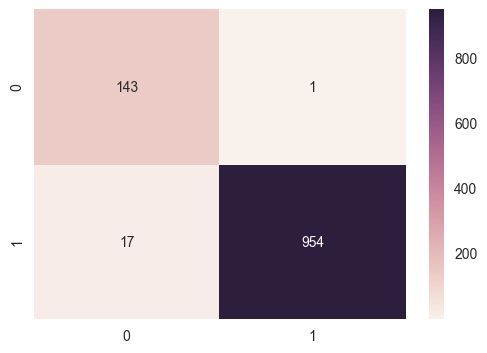

In [101]:
sns.heatmap(metrics.confusion_matrix(best_pipe.predict(X_test), y_test), annot=True,  fmt='');

In [102]:
print(metrics.classification_report(best_pipe.predict(X_test), y_test))

             precision    recall  f1-score   support

          0       0.89      0.99      0.94       144
          1       1.00      0.98      0.99       971

avg / total       0.99      0.98      0.98      1115



This is a small improvement for humanity and also for us sadly :(. But we could do better with a different classifier, with more parameters,
and even using grid search instead of randomized! There are paramters that wait for us to optimize!